# Introduction

This notebook implements Differential Evolution with Novel Parameter Control (DE-NPC) proposed by Meng et al. (2020) [1]. 

Using DE-NPC and MNIST [2], an adversarial image is generated. The prediction of an RBF Network on the adversarial image and original image is displayed.

[1] Meng, Z., Chen, Y., & Li, X. (2020). Enhancing differential evolution with novel parametercontrol. IEEE Access,8, 51145–51167. \\
[2] LeCun, Y., Cortes, C., & Burges, C.  (2010). MNIST handwritten digit database.



# Libraries

In [1]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
import tensorflow as tf
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Activation
from keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from scipy.stats import cauchy 
from scipy import stats
import time
import operator
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from keras.models import load_model
from skimage.measure import compare_ssim as ssim
import pickle

#Set seeds
random.seed(1)
np.random.seed(1)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# DE_NPC Class

In [0]:
#https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/
from math import log10, sqrt 
import cv2 
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [0]:
# https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
def euclidean(s):
    # pass s=a-b as argument to the function
    return np.linalg.norm(s)

In [0]:
class DE_NPC:
  def __init__(self,param_dict):
    ###Load Params##
    self.img = param_dict["input"]
    self.imsize = param_dict["input_size"]
    self.imclass = param_dict["imclass"]
    self.mean = param_dict["mean"]
    self.std = param_dict["std"]
    self.R_min = param_dict["R_min"]
    self.R_max = param_dict["R_max"]
    self.nfe_max = param_dict["nfe_max"]
    self.PS_ini = param_dict["PS_ini"]
    self.PS_min = param_dict["PS_min"]
    self.K = param_dict["K"]
    self.rarc = param_dict["rarc"]
    self.p = param_dict["p"]
    self.model = param_dict["model"]

    ####Initialize Params####
    self.set_params()

  #Fitness function
  def fitness_func(self,individual):
    individual = individual.reshape(1,int(np.sqrt(self.imsize)),int(np.sqrt(self.imsize)),1)
    pred = self.model.predict(individual  / 255.0)
    pred = pred[0]
    po = pred[self.imclass]
    pred[self.imclass] = 0
    pd = np.max(pred)
    diff = pd-po
    return (0.5)*diff + (-0.5)*euclidean(individual-self.img.reshape(1,self.imsize))/(self.imsize*255) 

  #Given the population and img(whihc is necessary to calculate the fitness function)
  #choose one individual whose fitness value is in top p percent.
  def get_top_p(self,PS,p):
    num_best = int(PS*p)
    fitness =  [(individual,self.fitness_func(individual)) for individual in self.population[0:PS]]
    fitness.sort(key=lambda x: x[1])
    fitness = fitness[-num_best:]
    return random.choice(fitness)[0]

  def execute(self, model):
    not_improving = 0
    nfe = 0
    PS = self.PS_ini
    A_ind = 0
    G = 1
    start = time.time()
    while nfe < self.nfe_max:
      #############################INITIALIZATION###################################
      #Sets of successfull f and cr values
      #with the corresponding weights
      s_f = [[] for i in range(self.K)]
      s_f_weights = [[] for i in range(self.K)]
      s_cr = [[] for i in range(self.K)]
      s_cr_weights = [[] for i in range(self.K)]
      #the selected k values for this iteration
      k_selections = np.zeros((self.K,PS))
      #how many times the specific k value was a success/failure
      k_success = np.zeros((self.K,1))
      k_failure = np.zeros((self.K,1))

      ####################ADJUST POPULATION AND A###################################
      #Adjustment done due to keep the individuals' values in range.
      #and to reduce the array sizes. However, even if the population size gets 
      #smaller than PS, since the loops are in range(PS), the individuals stored in 
      #the population vector in indices > PS will not be reached. 
      #Instead of picking discarded individuals randomly, we shuffle the population
      #and archive array. It should amount to picking random.
      if G > 2:
        #Adjust the individuals of the population; 
        for i in range(PS):
          self.population[i] = np.clip(self.population[i], self.R_min, self.R_max).reshape(self.imsize)
        #Adjust storage A; 
        for i in range(self.A_size):
          self.A[i] = np.clip(self.A[i], self.R_min, self.R_max).reshape(self.imsize)
        np.random.shuffle(self.A)
        np.random.shuffle(self.population)

      #############################SELECT K,F,CR'S##################################  
      #We select a k value for each individual in the population
      #with respect to the selection probabilities (p_k) of each k.
      custm = stats.rv_discrete(name='custm', values=(np.arange(self.K).reshape(self.K,1), self.p_k))
      k_selections = custm.rvs(size=PS)
      #Get f and cr values for each individual
      for i in range(PS):
        self.cr[i]  = np.random.normal(self.mu_cr[k_selections[i]], 0.1, 1)
        if self.cr[i] < 0:
          self.cr[i] = 0
        self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        while self.f[i] <= 0:
          self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        if self.f[i] > 1:
          self.f[i] = 1
      
      ####################GENERATE U,V AND CALCULATE FITNESS########################
      #Generate donor and trial (U and V) vectors
      #Calculate the fitness values
      for i in range(PS):
        X_p_best =  self.get_top_p(PS,self.p).reshape((self.imsize,1))
        #X_r_1 denotes a random vector selection from the current population
        X_r_1 = random.choice(self.population[:PS]).reshape((self.imsize,1))
        #X_hat_r_2 denotes a randomly selected solution from the union A and P
        X_hat_r_2 = random.choice(np.concatenate((self.population[:PS], self.A[:self.A_size]), axis=0)).reshape((self.imsize,1))
        #mutation, generate trial vector
        self.V[i] = (self.population[i].reshape((self.imsize,1)) + self.f[i]*(X_p_best - self.population[i].reshape((self.imsize,1)))
               + self.f[i]*(X_r_1 - X_hat_r_2)).reshape(self.imsize)
        #crossover, generate donor vector
        self.U[i] = self.population[i]
        for j in range(self.imsize):
          if random.uniform(0, 1) <= self.cr[i]:
            self.U[i][j] = self.V[i][j]
        self.fitness_ind[i] = self.fitness_func(self.population[i])
        self.fitness_U[i] = self.fitness_func(self.U[i])

      ################################INCREMENT nfe#################################
      #Increment nfe
      nfe += PS

      #####################DETERMINE UN/SUCCESSFULL#################################
      #Determine the successful and unsuccessful cr,f,k values.
      #Add unsuccessful individuals to the archive
      for i in range(PS):
        k = k_selections[i]
        if self.fitness_ind[i] <= self.fitness_U[i]:
          s_cr[k].append(self.cr[i])
          s_cr_weights[k].append(np.std(np.subtract(self.population[i],self.U[i])))
          s_f[k].append(self.f[i])
          s_f_weights[k].append(self.fitness_U[i]-self.fitness_ind[i])
          self.population[i] = self.U[i]
          k_success[k] += 1
        else:
          if A_ind >= self.A_size:
            A_ind = 0
          self.A[A_ind] = self.population[i]
          A_ind += 1
          k_failure[k] += 1

      ######################UPDATE MU_CR AND MU_F's#################################
      #update params (mixed with Jade-like update)
      for k in range(self.K):
        if len(s_cr[k]) != 0:
          s_cr_weights[k] = s_cr_weights[k]/np.sum(s_cr_weights[k])
          s_f_weights[k] = s_f_weights[k]/np.sum(s_f_weights[k])
          mean_cr = np.sum(np.multiply(np.square(s_cr[k]),s_cr_weights[k]))/np.sum(np.multiply(s_cr[k],s_cr_weights[k]))
          mean_f = np.sum(np.multiply(np.square(s_f[k]),s_f_weights[k]))/np.sum(np.multiply(s_f[k],s_f_weights[k]))  
          #update mu_cr
          if (np.max(s_cr[k]) > 0) and (self.mu_cr[k] != 0):
            self.mu_cr[k] = mean_cr
          #update mu_f
          self.mu_f[k] = mean_f

      ###########################UPDATE GROUP PROBS#################################
      #Update group probabilities
      for k in range(self.K):
        if k_success[k] != 0:
          k_success[k] = np.square(k_success[k])/(np.sum(k_success[k])*(k_success[k]+k_failure[k]))
        else:
          self.p_k[k] = 0.000000001
      self.p_k = self.p_k/np.sum(self.p_k)

      ###########################END ITERATION######################################
      #increment generation count
      G += 1
      #Get the best individual
      self.X_best = self.get_top_p(PS,1/PS)
      if G > 2: 
        dist = euclidean(self.X_best.reshape(1,self.imsize)-self.img.reshape(1,self.imsize))/(self.imsize*255) 
        individual = self.X_best.reshape(1,int(np.sqrt(self.imsize)),int(np.sqrt(self.imsize)),1)
        pred = self.model.predict(np.clip(individual, 0, 255)  / 255.0)
        pred = pred[0]
        pred = np.argmax(pred)
        if dist<0.001 and pred != self.imclass[0]:
          self.X_best_fitness = self.fitness_func(self.X_best)
          print("FOUND! " ,nfe, " : "  ,self.X_best_fitness,PS)
          break
        if np.abs(self.X_best_fitness-self.fitness_func(self.X_best)) < 0.001:
          not_improving += 1
          if not_improving > 30:
             self.X_best_fitness = self.fitness_func(self.X_best)
             print("NOT IMPROVING! ",nfe, " : "  ,self.X_best_fitness,PS)
             break
        else:
          not_improving = 0
        
      #Get the fitness of best individual
      self.X_best_fitness = self.fitness_func(self.X_best)
      #Give feedback
      print(nfe, " : "  ,self.X_best_fitness,PS)

      ######################ADJUST POPULATION SIZE##################################
      #adjust population size 
      #else part changed. there is something wrong with the formula on the paper.
      #since the ends of the two partial functions do not meet, when nfe > x the 
      #population increases. change is to fix this.
      if nfe <= self.x:
        PS = int(np.ceil((((self.y-self.PS_ini)/np.square(self.x-self.PS_ini))*np.square(nfe-self.PS_ini)) + self.PS_ini))
      else:
        initial_formula = int(np.floor((((self.y-self.PS_ini)/(self.x-self.PS_min))*(nfe-self.nfe_max)) + self.PS_min))
        if initial_formula < PS:
          PS = initial_formula
      #adjust archive size according to the new population
      self.A_size = int(self.rarc*PS)
      #Note: archive update moved within "Determine un/successful" as the computation
      #would be too redundant.  
    end = time.time()
    print("Time: ",end-start ," seconds")
    return end-start,nfe

  def change_input(self,img,imclass,imsize):
    self.img = img
    self.imsize = imsize
    self.imclass = imclass
    self.set_params()

  def set_params(self):
    #Calculate pivot for dynamic population change
    self.x = (1/3)*self.nfe_max
    self.y = (2/3)*self.PS_ini     
    #probability of belonging to a group
    self.p_k = np.ones((self.K,1))*(1/self.K)   
    #archive
    self.A_size = int(self.PS_ini*self.rarc)
    self.A = np.zeros((self.A_size,self.imsize))
    #scale factor
    self.f = np.ones((self.PS_ini,1)) 
    self.mu_f = np.ones((self.K,1)) *0.5
    #crossover probability
    self.cr = np.ones((self.PS_ini,1)) 
    self.mu_cr = np.ones((self.K,1)) *0.5
    #Initial population
    self.population = np.zeros((self.PS_ini,self.imsize))
    #Fitness functions
    self.fitness_ind = np.zeros((self.PS_ini,1))
    self.fitness_U = np.zeros((self.PS_ini,1))
    #donor and trial vectors
    self.V = np.zeros((self.PS_ini,self.imsize))
    self.U = np.zeros((self.PS_ini,self.imsize))
    for i in range(self.PS_ini):
      noisy_img = self.img + np.random.normal(self.mean, self.std, (self.imsize,1))
      self.population[i] = np.clip(noisy_img, 0, 255).reshape(self.imsize)
    self.X_best = None
    self.X_best_fitness = None

# Download Neural Network

In [0]:
model = load_model("CNN_CIFAR10_net3.h5")

In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)       

# Prepare Data

In [7]:
'''
import pickle
file_ = open('subset_cifar', 'wb')
pickle.dump(original, file_)
pickle.dump(adversarial, file_)
pickle.dump(original_y, file_)
pickle.dump(adversarial_y, file_)
file_.close()
'''

"\nimport pickle\nfile_ = open('subset_cifar', 'wb')\npickle.dump(original, file_)\npickle.dump(adversarial, file_)\npickle.dump(original_y, file_)\npickle.dump(adversarial_y, file_)\nfile_.close()\n"

In [0]:
import pickle
file_ = open('subset_cifar', 'rb')
dump = pickle.load(file_)
adversarial = pickle.load(file_)
dump = pickle.load(file_)
adversarial_y = pickle.load(file_)
file_.close()
del dump

# Evolve

In [0]:
param_dict = {
    "model" : model,
    #Image to be evolved
    "input" : adversarial[0].reshape((32*32,1)),
    "input_size" : 32*32,
    "imclass" : adversarial_y[0],
    #Mean and std for Gaussian noise
    #good results with 10-10
    "mean" : 0, #50(5)   #150 (1)
    "std" : 10, #50 (5) #200 (1) (it was 100)
    #Range
    "R_min" : 0.0,
    "R_max" : 255.0,
    #Maximum number of function evaluations
    "nfe_max" : 10000,#4000 #5000(6) #50000(3)  #10000 (2)
    #Initial and minimum population size
    "PS_ini" : 25, #100 #200(4)
    "PS_min" : 4,
    #Number of groups
    "K" : 7,
    #ratio of the external archive size to the whole population PS
    "rarc" : 1.6,
    #percentage p when we select an individual among top p fits
    "p" : 0.11
}

25  :  [-0.40181124] 25
50  :  [-0.10411133] 25
75  :  [0.13106303] 25
100  :  [0.22542441] 25
125  :  [0.21871783] 25
150  :  [0.27819633] 25
175  :  [0.2960456] 25
200  :  [0.2903915] 25
225  :  [0.31911188] 25
250  :  [0.32554013] 25
275  :  [0.32554013] 25
300  :  [0.32554013] 25
325  :  [0.32554013] 25
350  :  [0.32656968] 25
375  :  [0.3259989] 25
400  :  [0.32937062] 25
425  :  [0.3338064] 25
450  :  [0.33620209] 25
475  :  [0.34299767] 25
500  :  [0.34299767] 25
525  :  [0.34299767] 25
550  :  [0.34299767] 25
575  :  [0.34422827] 25
600  :  [0.34645045] 25
625  :  [0.3475985] 25
650  :  [0.3475985] 25
675  :  [0.34835577] 25
700  :  [0.34851485] 25
725  :  [0.34992316] 25
750  :  [0.35052818] 25
775  :  [0.3508494] 25
800  :  [0.35108697] 25
825  :  [0.35188958] 25
850  :  [0.35188958] 25
875  :  [0.35232204] 25
900  :  [0.35291368] 25
925  :  [0.35307455] 25
950  :  [0.35314828] 25
975  :  [0.35351247] 25
1000  :  [0.35368764] 25
1025  :  [0.35380828] 25
1050  :  [0.35380828] 

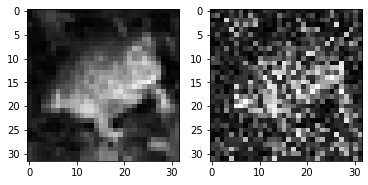

25  :  [-0.39812487] 25
50  :  [0.0595893] 25
75  :  [-0.01411027] 25
100  :  [0.14591925] 25
125  :  [0.01769698] 25
150  :  [0.07977583] 25
175  :  [0.10405967] 25
200  :  [0.18213147] 25
225  :  [0.21139137] 25
250  :  [0.19533323] 25
275  :  [0.22231877] 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide


300  :  [0.20322554] 25
325  :  [0.23553365] 25
350  :  [0.25659025] 25
375  :  [0.26224938] 25
400  :  [0.27316332] 25
425  :  [0.28058186] 25
450  :  [0.28058186] 25
475  :  [0.28058186] 25
500  :  [0.28535616] 25
525  :  [0.28535616] 25
550  :  [0.29489017] 25
575  :  [0.29493064] 25
600  :  [0.29493064] 25
625  :  [0.29493064] 25
650  :  [0.29993355] 25
675  :  [0.30085263] 25
700  :  [0.30084586] 25
725  :  [0.30084586] 25
750  :  [0.30262917] 25
775  :  [0.30262917] 25
800  :  [0.30878222] 25
825  :  [0.3090189] 25
850  :  [0.31119195] 25
875  :  [0.3111536] 25
900  :  [0.31198466] 25
925  :  [0.31472915] 25
950  :  [0.3147452] 25
975  :  [0.3166108] 25
1000  :  [0.31658143] 25
1025  :  [0.3174829] 25
1050  :  [0.3183177] 25
1075  :  [0.3183313] 25
1100  :  [0.3183313] 25
1125  :  [0.3183313] 25
1150  :  [0.3183313] 25
1175  :  [0.31840664] 25
1199  :  [0.3183313] 24
1223  :  [0.31851798] 24
1247  :  [0.31863415] 24
1271  :  [0.31878358] 24
1295  :  [0.31991082] 24
1319  :  [0.32

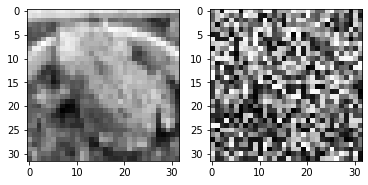

25  :  [0.25473642] 25
50  :  [0.25473642] 25
75  :  [0.23114365] 25
100  :  [0.22995195] 25
125  :  [0.23867665] 25
150  :  [0.2833801] 25
175  :  [0.28836912] 25
200  :  [0.28846604] 25
225  :  [0.28846604] 25
250  :  [0.29068398] 25
275  :  [0.29068398] 25
300  :  [0.29068398] 25
325  :  [0.29242802] 25
350  :  [0.29242802] 25
375  :  [0.29350984] 25
400  :  [0.29572755] 25
425  :  [0.2962507] 25
450  :  [0.29851106] 25
475  :  [0.2984984] 25
500  :  [0.2989248] 25
525  :  [0.2996598] 25
550  :  [0.2996598] 25
575  :  [0.29986107] 25
600  :  [0.30052286] 25
625  :  [0.3010643] 25
650  :  [0.30116513] 25
675  :  [0.30137944] 25
700  :  [0.30148464] 25
725  :  [0.30173928] 25
750  :  [0.30173928] 25
775  :  [0.30179936] 25
800  :  [0.30205336] 25
825  :  [0.30205336] 25
850  :  [0.30205336] 25
875  :  [0.30205336] 25
900  :  [0.3020917] 25
925  :  [0.3020917] 25
950  :  [0.30213094] 25
975  :  [0.30219418] 25
1000  :  [0.30219418] 25
1025  :  [0.3022181] 25
1050  :  [0.30222315] 25
10

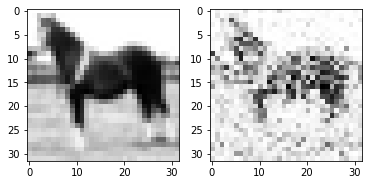

25  :  [0.2798952] 25
50  :  [0.2798952] 25
75  :  [0.3003291] 25
100  :  [0.30199847] 25
125  :  [0.30343574] 25
150  :  [0.3043657] 25
175  :  [0.30474734] 25
200  :  [0.30567175] 25
225  :  [0.30577737] 25
250  :  [0.306377] 25
275  :  [0.30677682] 25
300  :  [0.30677682] 25
325  :  [0.30677682] 25
350  :  [0.30731815] 25
375  :  [0.30731893] 25
400  :  [0.30737728] 25
425  :  [0.30739346] 25
450  :  [0.30755335] 25
475  :  [0.30774623] 25
500  :  [0.30785] 25
525  :  [0.30785] 25
550  :  [0.30795833] 25
575  :  [0.30795833] 25
600  :  [0.30795833] 25
625  :  [0.30795833] 25
650  :  [0.30815786] 25
675  :  [0.30815786] 25
700  :  [0.30818325] 25
725  :  [0.30818728] 25
750  :  [0.30822885] 25
775  :  [0.30822885] 25
800  :  [0.30824792] 25
825  :  [0.3082726] 25
850  :  [0.30828172] 25
875  :  [0.30828172] 25
NOT IMPROVING!  900  :  [0.30828863] 25
Time:  235.99898648262024  seconds
Predicted class:  [6]


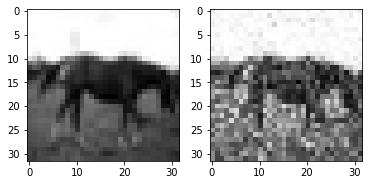

25  :  [0.30821115] 25
50  :  [0.3204932] 25
75  :  [0.3205578] 25
100  :  [0.3205578] 25
125  :  [0.3205578] 25
150  :  [0.3205799] 25
175  :  [0.32178098] 25
200  :  [0.3218264] 25
225  :  [0.3218264] 25
250  :  [0.3218264] 25
275  :  [0.32327068] 25
300  :  [0.323367] 25
325  :  [0.323367] 25
350  :  [0.3234505] 25
375  :  [0.32382417] 25
400  :  [0.32382417] 25
425  :  [0.3246928] 25
450  :  [0.32475385] 25
475  :  [0.32475567] 25
500  :  [0.3248005] 25
525  :  [0.3249488] 25
550  :  [0.3251683] 25
575  :  [0.3251763] 25
600  :  [0.3253562] 25
625  :  [0.32547247] 25
650  :  [0.3254918] 25
675  :  [0.3254918] 25
700  :  [0.32552022] 25
725  :  [0.3256185] 25
750  :  [0.3256185] 25
775  :  [0.32562476] 25
800  :  [0.32571822] 25
825  :  [0.32571822] 25
850  :  [0.3257502] 25
875  :  [0.3257952] 25
900  :  [0.32582584] 25
925  :  [0.32585898] 25
950  :  [0.32589585] 25
975  :  [0.32591683] 25
1000  :  [0.32592958] 25
1025  :  [0.32594305] 25
NOT IMPROVING!  1050  :  [0.32595396] 25
T

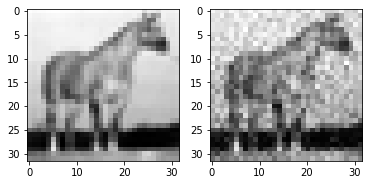

25  :  [0.27693912] 25
50  :  [0.32145423] 25
75  :  [0.32733792] 25
100  :  [0.3217284] 25
125  :  [0.32979354] 25
150  :  [0.32927614] 25
175  :  [0.33237314] 25
200  :  [0.3317464] 25
225  :  [0.33847967] 25
250  :  [0.33847967] 25
275  :  [0.33863807] 25
300  :  [0.33863807] 25
325  :  [0.346909] 25
350  :  [0.34718126] 25
375  :  [0.34718126] 25
400  :  [0.34718126] 25
425  :  [0.34718126] 25
450  :  [0.34718126] 25
475  :  [0.34718126] 25
500  :  [0.34718126] 25
525  :  [0.34929895] 25
550  :  [0.34929895] 25
575  :  [0.34929895] 25
600  :  [0.34931862] 25
625  :  [0.35119247] 25
650  :  [0.3513075] 25
675  :  [0.3513081] 25
700  :  [0.3513081] 25
725  :  [0.3517168] 25
750  :  [0.3517168] 25
775  :  [0.35188788] 25
800  :  [0.35201913] 25
825  :  [0.35223824] 25
850  :  [0.3525459] 25
875  :  [0.35298246] 25
900  :  [0.35327685] 25
925  :  [0.3533901] 25
950  :  [0.35352612] 25
975  :  [0.35352796] 25
1000  :  [0.3535996] 25
1025  :  [0.3536542] 25
1050  :  [0.35370958] 25
1075 

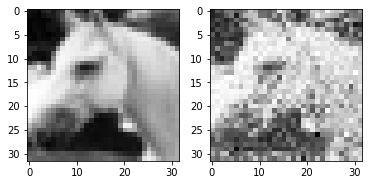

25  :  [0.305314] 25
50  :  [0.305314] 25
75  :  [0.30475405] 25
100  :  [0.30475405] 25
125  :  [0.30475405] 25
150  :  [0.30475405] 25
175  :  [0.30475405] 25
200  :  [0.30475405] 25
225  :  [0.30928645] 25
250  :  [0.30928645] 25
275  :  [0.30928645] 25
300  :  [0.30928645] 25
325  :  [0.30977446] 25
350  :  [0.3101451] 25
375  :  [0.3101451] 25
400  :  [0.3101451] 25
425  :  [0.31129688] 25
450  :  [0.31542963] 25
475  :  [0.31790602] 25
500  :  [0.31795672] 25
525  :  [0.31806976] 25
550  :  [0.31960785] 25
575  :  [0.32085997] 25
600  :  [0.3215029] 25
625  :  [0.32153702] 25
650  :  [0.32199854] 25
675  :  [0.32308364] 25
700  :  [0.32308364] 25
725  :  [0.32311064] 25
750  :  [0.32336718] 25
775  :  [0.32336718] 25
800  :  [0.3234987] 25
825  :  [0.32353732] 25
850  :  [0.3235808] 25
875  :  [0.32376438] 25
900  :  [0.3239351] 25
925  :  [0.3240803] 25
950  :  [0.3240803] 25
975  :  [0.3240803] 25
1000  :  [0.32413557] 25
1025  :  [0.3241468] 25
1050  :  [0.324161] 25
1075  :  

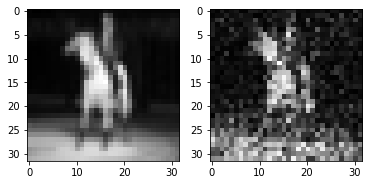

25  :  [0.3354835] 25
50  :  [0.3354835] 25
75  :  [0.3354835] 25
100  :  [0.34343112] 25
125  :  [0.35752213] 25
150  :  [0.3575092] 25
175  :  [0.3575092] 25
200  :  [0.36097044] 25
225  :  [0.36097044] 25
250  :  [0.36097044] 25
275  :  [0.36097044] 25
300  :  [0.36097044] 25
325  :  [0.36097044] 25
350  :  [0.36097044] 25
375  :  [0.37196636] 25
400  :  [0.3756897] 25
425  :  [0.3756897] 25
450  :  [0.37733406] 25
475  :  [0.3784907] 25
500  :  [0.3784907] 25
525  :  [0.3784907] 25
550  :  [0.3784907] 25
575  :  [0.3784907] 25
600  :  [0.3784907] 25
625  :  [0.3784907] 25
650  :  [0.3784907] 25
675  :  [0.3784907] 25
700  :  [0.3784907] 25
725  :  [0.3784907] 25
750  :  [0.37893686] 25
775  :  [0.37893686] 25
800  :  [0.3809855] 25
825  :  [0.3809855] 25
850  :  [0.3809855] 25
875  :  [0.3809855] 25
900  :  [0.3809855] 25
925  :  [0.38158345] 25
950  :  [0.38158345] 25
975  :  [0.38158345] 25
1000  :  [0.38158345] 25
1025  :  [0.38158345] 25
1050  :  [0.38240972] 25
1075  :  [0.382

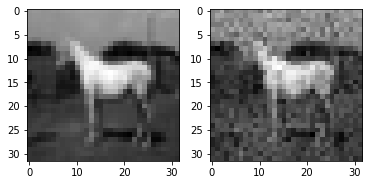

25  :  [0.3741637] 25
50  :  [0.3760056] 25
75  :  [0.39009953] 25
100  :  [0.39012882] 25
125  :  [0.3919744] 25
150  :  [0.39228344] 25
175  :  [0.39228344] 25
200  :  [0.39228344] 25
225  :  [0.3943586] 25
250  :  [0.39455965] 25
275  :  [0.39455965] 25
300  :  [0.39455965] 25
325  :  [0.39455965] 25
350  :  [0.39455965] 25
375  :  [0.39629722] 25
400  :  [0.39636922] 25
425  :  [0.39650816] 25
450  :  [0.3974153] 25
475  :  [0.3974187] 25
500  :  [0.39932695] 25
525  :  [0.39932695] 25
550  :  [0.3998444] 25
575  :  [0.3998444] 25
600  :  [0.3998444] 25
625  :  [0.3998444] 25
650  :  [0.3998444] 25
675  :  [0.39991996] 25
700  :  [0.39991996] 25
725  :  [0.40004766] 25
750  :  [0.4003452] 25
775  :  [0.4004807] 25
800  :  [0.4004807] 25
825  :  [0.40062386] 25
850  :  [0.40062386] 25
875  :  [0.40062386] 25
900  :  [0.40062386] 25
925  :  [0.40071267] 25
950  :  [0.40078703] 25
975  :  [0.40078703] 25
1000  :  [0.40078703] 25
1025  :  [0.40078703] 25
1050  :  [0.40081203] 25
1075  

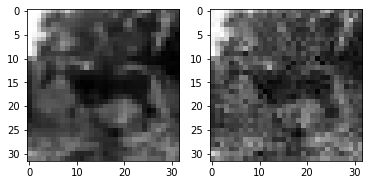

25  :  [0.33530682] 25
50  :  [0.33530682] 25
75  :  [0.33534822] 25
100  :  [0.33658323] 25
125  :  [0.33663616] 25
150  :  [0.33663616] 25
175  :  [0.33663616] 25
200  :  [0.33663616] 25
225  :  [0.33663616] 25
250  :  [0.33690923] 25
275  :  [0.3381027] 25
300  :  [0.3381027] 25
325  :  [0.3381027] 25
350  :  [0.3390375] 25
375  :  [0.33918208] 25
400  :  [0.33928382] 25
425  :  [0.3399384] 25
450  :  [0.3401552] 25
475  :  [0.34017718] 25
500  :  [0.34017718] 25
525  :  [0.34017718] 25
550  :  [0.34038562] 25
575  :  [0.3405733] 25
600  :  [0.34065866] 25
625  :  [0.34087366] 25
650  :  [0.34092164] 25
675  :  [0.34100106] 25
700  :  [0.34107226] 25
725  :  [0.3412946] 25
750  :  [0.3414111] 25
775  :  [0.3415026] 25
800  :  [0.3420318] 25
825  :  [0.3420318] 25
850  :  [0.34216624] 25
875  :  [0.3424588] 25
900  :  [0.34246528] 25
925  :  [0.34246528] 25
950  :  [0.34256747] 25
975  :  [0.3426882] 25
1000  :  [0.34283382] 25
1025  :  [0.34284604] 25
NOT IMPROVING!  1050  :  [0.342

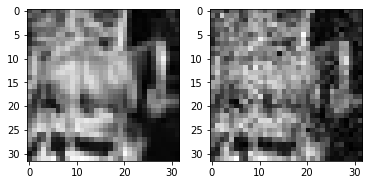

25  :  [0.35087574] 25
50  :  [0.35087574] 25
75  :  [0.35087574] 25
100  :  [0.35087574] 25
125  :  [0.35087574] 25
150  :  [0.35087574] 25
175  :  [0.35159576] 25
200  :  [0.35175842] 25
225  :  [0.35177085] 25
250  :  [0.35177085] 25
275  :  [0.35240746] 25
300  :  [0.35256428] 25
325  :  [0.35256428] 25
350  :  [0.35265628] 25
375  :  [0.35320163] 25
400  :  [0.35323447] 25
425  :  [0.35324496] 25
450  :  [0.35343868] 25
475  :  [0.3538971] 25
500  :  [0.35397232] 25
525  :  [0.35397232] 25
550  :  [0.35397232] 25
575  :  [0.35400742] 25
600  :  [0.35431594] 25
625  :  [0.35458514] 25
650  :  [0.3549962] 25
675  :  [0.3549962] 25
700  :  [0.3551675] 25
725  :  [0.3552416] 25
750  :  [0.35531378] 25
775  :  [0.35534042] 25
NOT IMPROVING!  800  :  [0.35534042] 25
Time:  208.9757833480835  seconds
Predicted class:  [4]


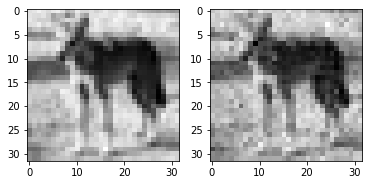

25  :  [0.33683348] 25
50  :  [0.33683348] 25
75  :  [0.33683348] 25
100  :  [0.33683348] 25
125  :  [0.33724648] 25
150  :  [0.3372692] 25
175  :  [0.3372692] 25
200  :  [0.33745974] 25
225  :  [0.33746368] 25
250  :  [0.33746368] 25
275  :  [0.3374864] 25
300  :  [0.33772627] 25
325  :  [0.33779657] 25
350  :  [0.33790225] 25
375  :  [0.33801442] 25
400  :  [0.33823574] 25
425  :  [0.33824426] 25
450  :  [0.3383633] 25
475  :  [0.3383633] 25
500  :  [0.33837727] 25
525  :  [0.3385172] 25
550  :  [0.33855283] 25
575  :  [0.3386032] 25
600  :  [0.33866277] 25
625  :  [0.3388319] 25
650  :  [0.33886743] 25
675  :  [0.33887696] 25
700  :  [0.33891708] 25
725  :  [0.3389756] 25
750  :  [0.3390567] 25
775  :  [0.33916748] 25
NOT IMPROVING!  800  :  [0.33919007] 25
Time:  208.31244325637817  seconds
Predicted class:  [6]


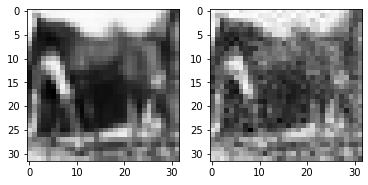

25  :  [0.31538486] 25
50  :  [0.32345825] 25
75  :  [0.3241266] 25
100  :  [0.32627714] 25
125  :  [0.32623845] 25
150  :  [0.32623845] 25
175  :  [0.32623845] 25
200  :  [0.32624298] 25
225  :  [0.32708687] 25
250  :  [0.32715285] 25
275  :  [0.32714567] 25
300  :  [0.32714567] 25
325  :  [0.32800132] 25
350  :  [0.32800132] 25
375  :  [0.32800132] 25
400  :  [0.3281641] 25
425  :  [0.3281893] 25
450  :  [0.32840568] 25
475  :  [0.32840568] 25
500  :  [0.32840568] 25
525  :  [0.32850784] 25
550  :  [0.32879984] 25
575  :  [0.32921857] 25
600  :  [0.3296821] 25
625  :  [0.32998204] 25
650  :  [0.33017963] 25
675  :  [0.33017963] 25
700  :  [0.33017963] 25
725  :  [0.33038753] 25
750  :  [0.33038753] 25
775  :  [0.33038753] 25
800  :  [0.33041692] 25
825  :  [0.33041874] 25
850  :  [0.33056003] 25
NOT IMPROVING!  875  :  [0.33056277] 25
Time:  231.2214756011963  seconds
Predicted class:  [6]


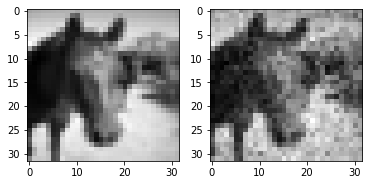

25  :  [0.37113667] 25
50  :  [0.37113667] 25
75  :  [0.37376606] 25
100  :  [0.37376606] 25
125  :  [0.37376606] 25
150  :  [0.37376606] 25
175  :  [0.3799171] 25
200  :  [0.3799171] 25
225  :  [0.38119993] 25
250  :  [0.38133484] 25
275  :  [0.3823574] 25
300  :  [0.3823574] 25
325  :  [0.3823574] 25
350  :  [0.3828324] 25
375  :  [0.3831206] 25
400  :  [0.38410467] 25
425  :  [0.38410467] 25
450  :  [0.38410467] 25
475  :  [0.38447225] 25
500  :  [0.38459843] 25
525  :  [0.38459843] 25
550  :  [0.38503957] 25
575  :  [0.38503957] 25
600  :  [0.38503957] 25
625  :  [0.3856104] 25
650  :  [0.3856104] 25
675  :  [0.38607836] 25
700  :  [0.38607836] 25
725  :  [0.38607836] 25
750  :  [0.38636103] 25
775  :  [0.38638377] 25
800  :  [0.3864038] 25
825  :  [0.38648924] 25
850  :  [0.3865652] 25
875  :  [0.3865652] 25
900  :  [0.38667062] 25
925  :  [0.38667062] 25
950  :  [0.38667062] 25
975  :  [0.38667262] 25
1000  :  [0.38667262] 25
1025  :  [0.38668022] 25
NOT IMPROVING!  1050  :  [0.3

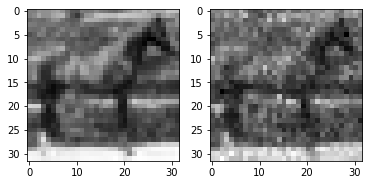

25  :  [0.3169917] 25
50  :  [0.33350387] 25
75  :  [0.33350387] 25
100  :  [0.33591542] 25
125  :  [0.3483801] 25
150  :  [0.34804448] 25
175  :  [0.36284506] 25
200  :  [0.36316895] 25
225  :  [0.36316895] 25
250  :  [0.36316895] 25
275  :  [0.3641466] 25
300  :  [0.36409986] 25
325  :  [0.36586916] 25
350  :  [0.36585623] 25
375  :  [0.36585623] 25
400  :  [0.36585623] 25
425  :  [0.36585623] 25
450  :  [0.36585623] 25
475  :  [0.36585623] 25
500  :  [0.36585623] 25
525  :  [0.36585623] 25
550  :  [0.36585623] 25
575  :  [0.36604154] 25
600  :  [0.36700368] 25
625  :  [0.36768636] 25
650  :  [0.3677902] 25
675  :  [0.36846933] 25
700  :  [0.3694861] 25
725  :  [0.3694861] 25
750  :  [0.3694861] 25
775  :  [0.3694861] 25
800  :  [0.3694861] 25
825  :  [0.36983615] 25
850  :  [0.36983615] 25
875  :  [0.3698635] 25
900  :  [0.36992604] 25
925  :  [0.36994448] 25
950  :  [0.3701337] 25
975  :  [0.37015238] 25
1000  :  [0.37024307] 25
1025  :  [0.3702721] 25
1050  :  [0.3702721] 25
1075 

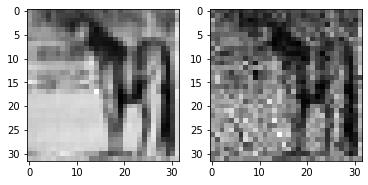

25  :  [0.2538589] 25
50  :  [0.2538589] 25
75  :  [0.29148513] 25
100  :  [0.29578716] 25
125  :  [0.29578716] 25
150  :  [0.30084676] 25
175  :  [0.30513853] 25
200  :  [0.30548304] 25
225  :  [0.30548304] 25
250  :  [0.30548304] 25
275  :  [0.30676365] 25
300  :  [0.30678865] 25
325  :  [0.30678865] 25
350  :  [0.30678865] 25
375  :  [0.30678865] 25
400  :  [0.30678865] 25
425  :  [0.30678865] 25
450  :  [0.30939066] 25
475  :  [0.3094005] 25
500  :  [0.3094005] 25
525  :  [0.3094005] 25
550  :  [0.3094005] 25
575  :  [0.3094005] 25
600  :  [0.3094005] 25
625  :  [0.3094005] 25
650  :  [0.3094005] 25
675  :  [0.3094244] 25
700  :  [0.30982074] 25
725  :  [0.31122524] 25
750  :  [0.31122524] 25
775  :  [0.31140548] 25
800  :  [0.31169373] 25
825  :  [0.31169897] 25
850  :  [0.3120079] 25
875  :  [0.31202745] 25
900  :  [0.31263888] 25
925  :  [0.31263888] 25
950  :  [0.31263888] 25
975  :  [0.31297058] 25
1000  :  [0.3131792] 25
1025  :  [0.31354243] 25
1050  :  [0.31395695] 25
1075 

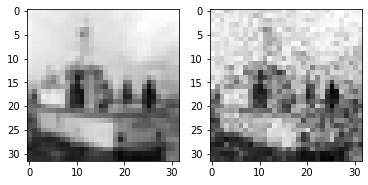

25  :  [0.35199082] 25
50  :  [0.35199082] 25
75  :  [0.35246944] 25
100  :  [0.35241118] 25
125  :  [0.35241118] 25
150  :  [0.35256058] 25
175  :  [0.3550986] 25
200  :  [0.3550986] 25
225  :  [0.3550986] 25
250  :  [0.3550986] 25
275  :  [0.35574895] 25
300  :  [0.35574895] 25
325  :  [0.35574895] 25
350  :  [0.35621333] 25
375  :  [0.35666078] 25
400  :  [0.35694173] 25
425  :  [0.35695013] 25
450  :  [0.35695013] 25
475  :  [0.35695013] 25
500  :  [0.35746035] 25
525  :  [0.35746035] 25
550  :  [0.3575402] 25
575  :  [0.35777247] 25
600  :  [0.35777247] 25
625  :  [0.35779056] 25
650  :  [0.35779056] 25
675  :  [0.35779056] 25
700  :  [0.35779056] 25
725  :  [0.35788888] 25
750  :  [0.35805684] 25
775  :  [0.35806286] 25
800  :  [0.35817847] 25
825  :  [0.35817847] 25
850  :  [0.3582641] 25
875  :  [0.3582641] 25
900  :  [0.35830575] 25
925  :  [0.35844105] 25
NOT IMPROVING!  950  :  [0.35844105] 25
Time:  254.60397362709045  seconds
Predicted class:  [2]


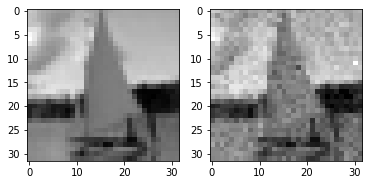

25  :  [0.37004185] 25
50  :  [0.37181115] 25
75  :  [0.37181115] 25
100  :  [0.37217513] 25
125  :  [0.37217513] 25
150  :  [0.37217513] 25
175  :  [0.37217513] 25
200  :  [0.37217513] 25
225  :  [0.37217513] 25
250  :  [0.37217513] 25
275  :  [0.37217513] 25
300  :  [0.37285984] 25
325  :  [0.37285984] 25
350  :  [0.37285984] 25
375  :  [0.37285984] 25
400  :  [0.37341827] 25
425  :  [0.37341827] 25
450  :  [0.37341827] 25
475  :  [0.37393662] 25
500  :  [0.37393662] 25
525  :  [0.37434414] 25
550  :  [0.37434414] 25
575  :  [0.37439364] 25
600  :  [0.3744573] 25
625  :  [0.37464666] 25
650  :  [0.37467784] 25
675  :  [0.37509137] 25
700  :  [0.37516147] 25
725  :  [0.37516147] 25
750  :  [0.37520567] 25
775  :  [0.37552032] 25
800  :  [0.37552032] 25
NOT IMPROVING!  825  :  [0.37552032] 25
Time:  218.27555632591248  seconds
Predicted class:  [2]


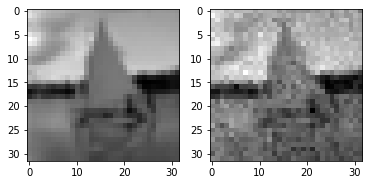

25  :  [0.25453353] 25
50  :  [0.30320287] 25
75  :  [0.3061452] 25
100  :  [0.3061452] 25
125  :  [0.3061452] 25
150  :  [0.3061452] 25
175  :  [0.3061452] 25
200  :  [0.3061452] 25
225  :  [0.30984032] 25
250  :  [0.31165883] 25
275  :  [0.31930047] 25
300  :  [0.32643908] 25
325  :  [0.32604933] 25
350  :  [0.32604933] 25
375  :  [0.33206525] 25
400  :  [0.33224827] 25
425  :  [0.33224827] 25
450  :  [0.33224827] 25
475  :  [0.33224827] 25
500  :  [0.3341118] 25
525  :  [0.33577782] 25
550  :  [0.33577782] 25
575  :  [0.33691797] 25
600  :  [0.3369546] 25
625  :  [0.3369546] 25
650  :  [0.3369546] 25
675  :  [0.3369546] 25
700  :  [0.3377368] 25
725  :  [0.3378812] 25
750  :  [0.3392331] 25
775  :  [0.33923393] 25
800  :  [0.34005344] 25
825  :  [0.34005395] 25
850  :  [0.34005395] 25
875  :  [0.34058303] 25
900  :  [0.34058303] 25
925  :  [0.34058303] 25
950  :  [0.34058303] 25
975  :  [0.3409416] 25
1000  :  [0.34134603] 25
1025  :  [0.34148747] 25
1050  :  [0.34186077] 25
1075  :

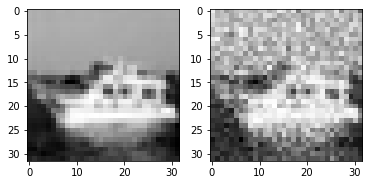

25  :  [0.3137834] 25
50  :  [0.31417125] 25
75  :  [0.31463102] 25
100  :  [0.31477505] 25
125  :  [0.31480205] 25
150  :  [0.31487122] 25
175  :  [0.31487122] 25
200  :  [0.31580478] 25
225  :  [0.31608516] 25
250  :  [0.31608516] 25
275  :  [0.31608516] 25
300  :  [0.31608516] 25
325  :  [0.31659606] 25
350  :  [0.31669295] 25
375  :  [0.31674892] 25
400  :  [0.31674892] 25
425  :  [0.31674892] 25
450  :  [0.31674892] 25
475  :  [0.31674892] 25
500  :  [0.31676483] 25
525  :  [0.31676483] 25
550  :  [0.31676483] 25
575  :  [0.3169939] 25
600  :  [0.3170055] 25
625  :  [0.31702977] 25
650  :  [0.31709898] 25
675  :  [0.31739044] 25
700  :  [0.31739044] 25
725  :  [0.31739044] 25
750  :  [0.31742978] 25
775  :  [0.31743062] 25
NOT IMPROVING!  800  :  [0.31759065] 25
Time:  208.8732566833496  seconds
Predicted class:  [6]


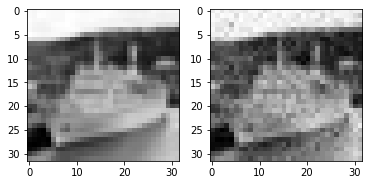

25  :  [0.2209301] 25
50  :  [0.2209301] 25
75  :  [0.2779596] 25
100  :  [0.2779596] 25
125  :  [0.2779596] 25
150  :  [0.2779596] 25
175  :  [0.27933842] 25
200  :  [0.27931085] 25
225  :  [0.27931085] 25
250  :  [0.28137743] 25
275  :  [0.28137085] 25
300  :  [0.28300646] 25
325  :  [0.28325683] 25
350  :  [0.28325683] 25
375  :  [0.28325683] 25
400  :  [0.28425938] 25
425  :  [0.28708535] 25
450  :  [0.28711647] 25
475  :  [0.28711647] 25
500  :  [0.28756866] 25
525  :  [0.28756997] 25
550  :  [0.28756997] 25
575  :  [0.28756997] 25
600  :  [0.2877832] 25
625  :  [0.2877832] 25
650  :  [0.28942293] 25
675  :  [0.2903242] 25
700  :  [0.2903242] 25
725  :  [0.29033047] 25
750  :  [0.29053771] 25
775  :  [0.29053771] 25
800  :  [0.29079473] 25
825  :  [0.29079473] 25
850  :  [0.29090762] 25
875  :  [0.29106718] 25
900  :  [0.2911229] 25
925  :  [0.29113582] 25
950  :  [0.29117507] 25
975  :  [0.2911952] 25
1000  :  [0.2911952] 25
1025  :  [0.29123408] 25
1050  :  [0.2913502] 25
1075  

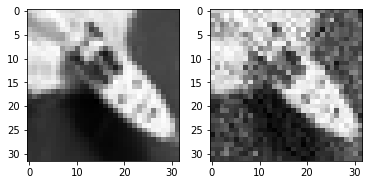

25  :  [0.30425787] 25
50  :  [0.3348296] 25
75  :  [0.3348296] 25
100  :  [0.36076745] 25
125  :  [0.36075714] 25
150  :  [0.36075714] 25
175  :  [0.36075714] 25
200  :  [0.36409393] 25
225  :  [0.36409393] 25
250  :  [0.36409393] 25
275  :  [0.3782857] 25
300  :  [0.3782857] 25
325  :  [0.3782857] 25
350  :  [0.3782857] 25
375  :  [0.3782857] 25
400  :  [0.3782857] 25
425  :  [0.3782857] 25
450  :  [0.3795828] 25
475  :  [0.38222456] 25
500  :  [0.38222456] 25
525  :  [0.38222456] 25
550  :  [0.38391495] 25
575  :  [0.38391495] 25
600  :  [0.38545087] 25
625  :  [0.38545087] 25
650  :  [0.38545087] 25
675  :  [0.38545087] 25
700  :  [0.3854908] 25
725  :  [0.3854908] 25
750  :  [0.3874622] 25
775  :  [0.3874622] 25
800  :  [0.38749343] 25
825  :  [0.3880587] 25
850  :  [0.38838288] 25
875  :  [0.38850746] 25
900  :  [0.38851568] 25
925  :  [0.38884485] 25
950  :  [0.38893282] 25
975  :  [0.3893008] 25
1000  :  [0.38931268] 25
1025  :  [0.38935983] 25
1050  :  [0.38935983] 25
1075  : 

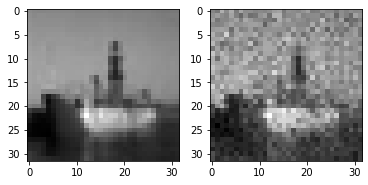

25  :  [0.34398046] 25
50  :  [0.34398046] 25
75  :  [0.3448161] 25
100  :  [0.34730732] 25
125  :  [0.34732914] 25
150  :  [0.34780765] 25
175  :  [0.3477875] 25
200  :  [0.34836048] 25
225  :  [0.34835488] 25
250  :  [0.34835488] 25
275  :  [0.34886506] 25
300  :  [0.34886506] 25
325  :  [0.34886506] 25
350  :  [0.34886506] 25
375  :  [0.34920257] 25
400  :  [0.34920257] 25
425  :  [0.34920257] 25
450  :  [0.34948635] 25
475  :  [0.34957144] 25
500  :  [0.3497159] 25
525  :  [0.3497611] 25
550  :  [0.34976226] 25
575  :  [0.34979936] 25
600  :  [0.34979936] 25
625  :  [0.34979936] 25
650  :  [0.34985778] 25
675  :  [0.34990636] 25
700  :  [0.3499491] 25
725  :  [0.3499491] 25
750  :  [0.349975] 25
775  :  [0.349975] 25
800  :  [0.34999114] 25
825  :  [0.35002697] 25
850  :  [0.35002697] 25
NOT IMPROVING!  875  :  [0.3500425] 25
Time:  232.03999280929565  seconds
Predicted class:  [6]


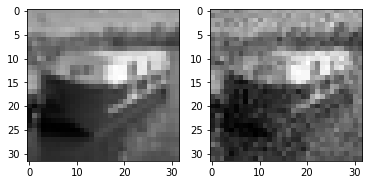

25  :  [0.33594114] 25
50  :  [0.33594114] 25
75  :  [0.33595937] 25
100  :  [0.33714128] 25
125  :  [0.33727545] 25
150  :  [0.33727545] 25
175  :  [0.33727545] 25
200  :  [0.3374011] 25
225  :  [0.3375215] 25
250  :  [0.33751184] 25
275  :  [0.33751184] 25
300  :  [0.33762822] 25
325  :  [0.33853823] 25
350  :  [0.33882016] 25
375  :  [0.3392029] 25
400  :  [0.3392029] 25
425  :  [0.3392029] 25
450  :  [0.33920676] 25
475  :  [0.33934635] 25
500  :  [0.33934635] 25
525  :  [0.33937413] 25
550  :  [0.3393848] 25
575  :  [0.3396349] 25
600  :  [0.33965182] 25
625  :  [0.3397175] 25
650  :  [0.33982384] 25
675  :  [0.33985278] 25
700  :  [0.33992386] 25
725  :  [0.33992386] 25
750  :  [0.33992386] 25
775  :  [0.33992553] 25
800  :  [0.33997607] 25
825  :  [0.339994] 25
850  :  [0.34000972] 25
NOT IMPROVING!  875  :  [0.34006977] 25
Time:  235.65871858596802  seconds
Predicted class:  [2]


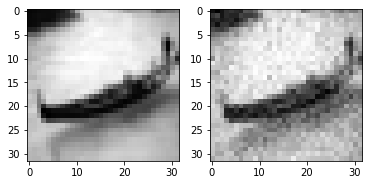

25  :  [0.3838483] 25
50  :  [0.3838483] 25
75  :  [0.389836] 25
100  :  [0.3898735] 25
125  :  [0.3898735] 25
150  :  [0.3898735] 25
175  :  [0.3898735] 25
200  :  [0.3898735] 25
225  :  [0.39119017] 25
250  :  [0.39207038] 25
275  :  [0.39207038] 25
300  :  [0.39207038] 25
325  :  [0.39207038] 25
350  :  [0.39247283] 25
375  :  [0.39247283] 25
400  :  [0.39247283] 25
425  :  [0.39247283] 25
450  :  [0.39247283] 25
475  :  [0.39247283] 25
500  :  [0.3929031] 25
525  :  [0.39291286] 25
550  :  [0.39291286] 25
575  :  [0.39328635] 25
600  :  [0.39328635] 25
625  :  [0.39339215] 25
650  :  [0.3939756] 25
675  :  [0.3939756] 25
700  :  [0.3943636] 25
725  :  [0.39442432] 25
750  :  [0.39449456] 25
775  :  [0.39449456] 25
800  :  [0.39449456] 25
825  :  [0.39487815] 25
850  :  [0.39498216] 25
875  :  [0.395027] 25
900  :  [0.39515895] 25
925  :  [0.39518774] 25
950  :  [0.39523512] 25
975  :  [0.39533123] 25
NOT IMPROVING!  1000  :  [0.39533123] 25
Time:  271.89695739746094  seconds
Predic

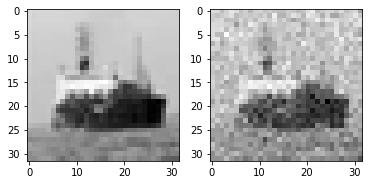

25  :  [0.29849494] 25
50  :  [0.3011651] 25
75  :  [0.3017763] 25
100  :  [0.3029408] 25
125  :  [0.30321944] 25
150  :  [0.30321944] 25
175  :  [0.30321944] 25
200  :  [0.30333358] 25
225  :  [0.30367395] 25
250  :  [0.3036763] 25
275  :  [0.3036763] 25
300  :  [0.30415273] 25
325  :  [0.30414802] 25
350  :  [0.3043359] 25
375  :  [0.3045532] 25
400  :  [0.3055038] 25
425  :  [0.30550128] 25
450  :  [0.30550128] 25
475  :  [0.30562687] 25
500  :  [0.30563515] 25
525  :  [0.30594242] 25
550  :  [0.30615732] 25
575  :  [0.30615926] 25
600  :  [0.3061744] 25
625  :  [0.30620807] 25
650  :  [0.3063745] 25
675  :  [0.3063745] 25
700  :  [0.3063745] 25
725  :  [0.3063745] 25
750  :  [0.30651915] 25
775  :  [0.30652228] 25
800  :  [0.306558] 25
825  :  [0.3065998] 25
850  :  [0.30688345] 25
NOT IMPROVING!  875  :  [0.30688953] 25
Time:  240.7117781639099  seconds
Predicted class:  [2]


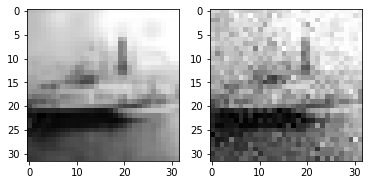

25  :  [0.30812126] 25
50  :  [0.34054887] 25
75  :  [0.34023666] 25
100  :  [0.34023666] 25
125  :  [0.3407401] 25
150  :  [0.34491307] 25
175  :  [0.34510636] 25
200  :  [0.3496318] 25
225  :  [0.3496328] 25
250  :  [0.3496328] 25
275  :  [0.3496328] 25
300  :  [0.35048634] 25
325  :  [0.35130078] 25
350  :  [0.35130078] 25
375  :  [0.35130078] 25
400  :  [0.35130078] 25
425  :  [0.35130078] 25
450  :  [0.35130078] 25
475  :  [0.35199672] 25
500  :  [0.3520808] 25
525  :  [0.35262161] 25
550  :  [0.35262161] 25
575  :  [0.35405543] 25
600  :  [0.35405543] 25
625  :  [0.35405543] 25
650  :  [0.35405543] 25
675  :  [0.35409105] 25
700  :  [0.35428083] 25
725  :  [0.35446155] 25
750  :  [0.35454947] 25
775  :  [0.35484704] 25
800  :  [0.35484704] 25
825  :  [0.35501665] 25
850  :  [0.35501665] 25
875  :  [0.35515895] 25
900  :  [0.35515895] 25
925  :  [0.35515895] 25
950  :  [0.35515895] 25
975  :  [0.35515895] 25
1000  :  [0.35515895] 25
1025  :  [0.35523313] 25
1050  :  [0.35539216] 2

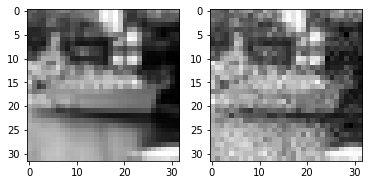

25  :  [0.43544626] 25
50  :  [0.43544626] 25
75  :  [0.43816015] 25
100  :  [0.43816015] 25
125  :  [0.43860418] 25
150  :  [0.43860418] 25
175  :  [0.43860418] 25
200  :  [0.43860418] 25
225  :  [0.43860418] 25
250  :  [0.43860418] 25
275  :  [0.43860418] 25
300  :  [0.43860418] 25
325  :  [0.440179] 25
350  :  [0.440179] 25
375  :  [0.440179] 25
400  :  [0.440179] 25
425  :  [0.4440838] 25
450  :  [0.4440838] 25
475  :  [0.4440838] 25
500  :  [0.4440838] 25
525  :  [0.4440838] 25
550  :  [0.444355] 25
575  :  [0.444355] 25
600  :  [0.444355] 25
625  :  [0.444355] 25
650  :  [0.444355] 25
675  :  [0.444355] 25
700  :  [0.444355] 25
725  :  [0.444355] 25
750  :  [0.444355] 25
775  :  [0.444355] 25
800  :  [0.4445344] 25
825  :  [0.4445344] 25
850  :  [0.4445344] 25
875  :  [0.4445344] 25
900  :  [0.4445344] 25
925  :  [0.4445344] 25
950  :  [0.4445344] 25
975  :  [0.4462511] 25
1000  :  [0.4462511] 25
1025  :  [0.44626132] 25
1050  :  [0.44648597] 25
1075  :  [0.44648597] 25
1100  :  

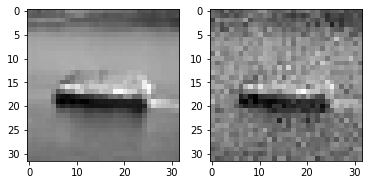

25  :  [0.33150786] 25
50  :  [0.33150786] 25
75  :  [0.3403125] 25
100  :  [0.34035546] 25
125  :  [0.35373354] 25
150  :  [0.35373354] 25
175  :  [0.35373354] 25
200  :  [0.35671902] 25
225  :  [0.35686606] 25
250  :  [0.3578782] 25
275  :  [0.3603071] 25
300  :  [0.36049548] 25
325  :  [0.3628235] 25
350  :  [0.36287618] 25
375  :  [0.36287618] 25
400  :  [0.36287618] 25
425  :  [0.36321104] 25
450  :  [0.36353403] 25
475  :  [0.3635792] 25
500  :  [0.3638261] 25
525  :  [0.3638261] 25
550  :  [0.36407897] 25
575  :  [0.36440718] 25
600  :  [0.3644939] 25
625  :  [0.36458313] 25
650  :  [0.36458313] 25
675  :  [0.36469674] 25
700  :  [0.36475194] 25
725  :  [0.36493394] 25
750  :  [0.36506733] 25
775  :  [0.36506733] 25
800  :  [0.36506733] 25
825  :  [0.36516562] 25
850  :  [0.36522675] 25
875  :  [0.36526096] 25
900  :  [0.36527267] 25
925  :  [0.36527267] 25
950  :  [0.36528435] 25
975  :  [0.36531115] 25
1000  :  [0.36531115] 25
1025  :  [0.36533406] 25
1050  :  [0.365337] 25
10

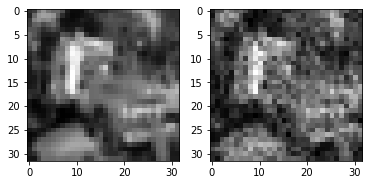

25  :  [0.25176454] 25
50  :  [0.25176454] 25
75  :  [0.2613625] 25
100  :  [0.2677977] 25
125  :  [0.28876692] 25
150  :  [0.288562] 25
175  :  [0.288562] 25
200  :  [0.288562] 25
225  :  [0.288562] 25
250  :  [0.28892055] 25
275  :  [0.28892055] 25
300  :  [0.29357868] 25
325  :  [0.29357868] 25
350  :  [0.29700541] 25
375  :  [0.297005] 25
400  :  [0.297005] 25
425  :  [0.297005] 25
450  :  [0.29816762] 25
475  :  [0.29967552] 25
500  :  [0.29967552] 25
525  :  [0.30018103] 25
550  :  [0.30041993] 25
575  :  [0.30041993] 25
600  :  [0.30041993] 25
625  :  [0.30044168] 25
650  :  [0.30044168] 25
675  :  [0.3004548] 25
700  :  [0.30058753] 25
725  :  [0.30064207] 25
750  :  [0.30064207] 25
775  :  [0.30078164] 25
800  :  [0.30078185] 25
825  :  [0.30096918] 25
850  :  [0.30096918] 25
875  :  [0.30099297] 25
900  :  [0.30106378] 25
925  :  [0.3011143] 25
950  :  [0.30117244] 25
975  :  [0.30119646] 25
1000  :  [0.30123046] 25
1025  :  [0.30123046] 25
1050  :  [0.3012556] 25
1075  :  [0

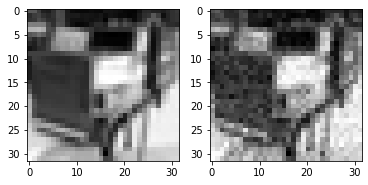

25  :  [0.30105293] 25
50  :  [0.30105293] 25
75  :  [0.29855233] 25
100  :  [0.29855233] 25
125  :  [0.30159086] 25
150  :  [0.30154878] 25
175  :  [0.30154878] 25
200  :  [0.30154878] 25
225  :  [0.30154878] 25
250  :  [0.3023461] 25
275  :  [0.30250543] 25
300  :  [0.30250543] 25
325  :  [0.30250543] 25
350  :  [0.303483] 25
375  :  [0.30825597] 25
400  :  [0.30846596] 25
425  :  [0.30846596] 25
450  :  [0.30846596] 25
475  :  [0.30846596] 25
500  :  [0.30846596] 25
525  :  [0.3085029] 25
550  :  [0.3085029] 25
575  :  [0.30885458] 25
600  :  [0.30975705] 25
625  :  [0.31006205] 25
650  :  [0.31006205] 25
675  :  [0.31038538] 25
700  :  [0.31093568] 25
725  :  [0.31093988] 25
750  :  [0.31119028] 25
775  :  [0.3116094] 25
800  :  [0.31170538] 25
825  :  [0.31170738] 25
850  :  [0.3117203] 25
875  :  [0.31221235] 25
900  :  [0.31221235] 25
925  :  [0.31233332] 25
950  :  [0.31243414] 25
975  :  [0.31251258] 25
1000  :  [0.3125714] 25
1025  :  [0.31260353] 25
1050  :  [0.312641] 25
10

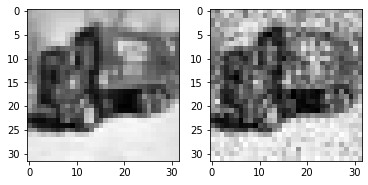

25  :  [0.32833406] 25
50  :  [0.33410758] 25
75  :  [0.33404028] 25
100  :  [0.33404028] 25
125  :  [0.33404028] 25
150  :  [0.33404028] 25
175  :  [0.33404028] 25
200  :  [0.33404028] 25
225  :  [0.33404028] 25
250  :  [0.33404028] 25
275  :  [0.33917898] 25
300  :  [0.33917898] 25
325  :  [0.340618] 25
350  :  [0.340618] 25
375  :  [0.340618] 25
400  :  [0.340618] 25
425  :  [0.340618] 25
450  :  [0.34083328] 25
475  :  [0.34083328] 25
500  :  [0.34083328] 25
525  :  [0.34083328] 25
550  :  [0.34083328] 25
575  :  [0.34169072] 25
600  :  [0.34169224] 25
625  :  [0.34169224] 25
650  :  [0.34169224] 25
675  :  [0.34169224] 25
700  :  [0.34271106] 25
725  :  [0.34271106] 25
750  :  [0.3428728] 25
775  :  [0.3428728] 25
800  :  [0.3434363] 25
825  :  [0.3436495] 25
850  :  [0.34364688] 25
875  :  [0.34377015] 25
900  :  [0.34377944] 25
925  :  [0.34380084] 25
950  :  [0.34390774] 25
975  :  [0.34390774] 25
1000  :  [0.34390774] 25
1025  :  [0.34390774] 25
1050  :  [0.34395105] 25
1075  

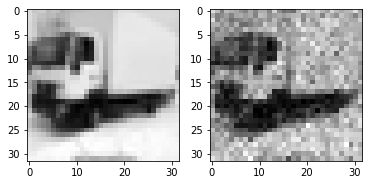

25  :  [0.32812542] 25
50  :  [0.32812542] 25
75  :  [0.33758503] 25
100  :  [0.3348456] 25
125  :  [0.33613467] 25
150  :  [0.33928645] 25
175  :  [0.34351063] 25
200  :  [0.35205153] 25
225  :  [0.35206148] 25
250  :  [0.35325944] 25
275  :  [0.35387743] 25
300  :  [0.35387743] 25
325  :  [0.35387743] 25
350  :  [0.35692483] 25
375  :  [0.35692483] 25
400  :  [0.35692483] 25
425  :  [0.35692483] 25
450  :  [0.35692483] 25
475  :  [0.35692483] 25
500  :  [0.35692483] 25
525  :  [0.35692483] 25
550  :  [0.35692483] 25
575  :  [0.35692483] 25
600  :  [0.35692483] 25
625  :  [0.35839194] 25
650  :  [0.35849333] 25
675  :  [0.35871255] 25
700  :  [0.35872027] 25
725  :  [0.35958368] 25
750  :  [0.35959786] 25
775  :  [0.35959786] 25
800  :  [0.35962853] 25
825  :  [0.35962853] 25
850  :  [0.35962853] 25
875  :  [0.35995594] 25
900  :  [0.36036614] 25
925  :  [0.36090028] 25
950  :  [0.36090124] 25
975  :  [0.36090124] 25
1000  :  [0.36090124] 25
1025  :  [0.36090893] 25
1050  :  [0.360992

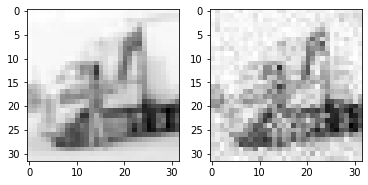

25  :  [0.22232886] 25
50  :  [0.22232886] 25
75  :  [0.23755708] 25
100  :  [0.22944723] 25
125  :  [0.22944723] 25
150  :  [0.22944723] 25
175  :  [0.255366] 25
200  :  [0.255366] 25
225  :  [0.255366] 25
250  :  [0.255366] 25
275  :  [0.255366] 25
300  :  [0.255366] 25
325  :  [0.255366] 25
350  :  [0.25647908] 25
375  :  [0.25647908] 25
400  :  [0.25990662] 25
425  :  [0.26007545] 25
450  :  [0.26007545] 25
475  :  [0.26554784] 25
500  :  [0.27030498] 25
525  :  [0.27030498] 25
550  :  [0.27030498] 25
575  :  [0.27064395] 25
600  :  [0.27117676] 25
625  :  [0.27118996] 25
650  :  [0.27390158] 25
675  :  [0.27428925] 25
700  :  [0.2744134] 25
725  :  [0.2750678] 25
750  :  [0.2759132] 25
775  :  [0.27593002] 25
800  :  [0.27659506] 25
825  :  [0.27689326] 25
850  :  [0.27689326] 25
875  :  [0.27689326] 25
900  :  [0.2771803] 25
925  :  [0.27739552] 25
950  :  [0.27739552] 25
975  :  [0.2774704] 25
1000  :  [0.27749634] 25
1025  :  [0.27755764] 25
1050  :  [0.27772078] 25
1075  :  [0

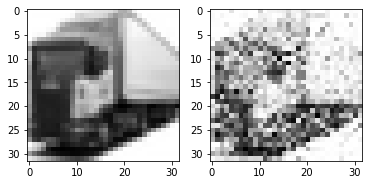

25  :  [0.29444322] 25
50  :  [0.30218536] 25
75  :  [0.30299088] 25
100  :  [0.30299088] 25
125  :  [0.30299088] 25
150  :  [0.30832696] 25
175  :  [0.30837476] 25
200  :  [0.30837476] 25
225  :  [0.30837476] 25
250  :  [0.30837476] 25
275  :  [0.30837476] 25
300  :  [0.30837476] 25
325  :  [0.31290808] 25
350  :  [0.31290784] 25
375  :  [0.31290784] 25
400  :  [0.31290784] 25
425  :  [0.31449422] 25
450  :  [0.31519693] 25
475  :  [0.31519693] 25
500  :  [0.31519693] 25
525  :  [0.31519693] 25
550  :  [0.31579375] 25
575  :  [0.31610638] 25
600  :  [0.31634682] 25
625  :  [0.31714633] 25
650  :  [0.31714633] 25
675  :  [0.31714633] 25
700  :  [0.31714633] 25
725  :  [0.31747782] 25
750  :  [0.31787357] 25
775  :  [0.3179007] 25
800  :  [0.31798428] 25
825  :  [0.3183059] 25
850  :  [0.31837773] 25
875  :  [0.31878287] 25
900  :  [0.31878287] 25
925  :  [0.31886798] 25
950  :  [0.3188974] 25
975  :  [0.3188974] 25
1000  :  [0.3188974] 25
1025  :  [0.31904447] 25
1050  :  [0.3190974] 2

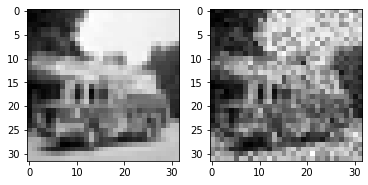

25  :  [0.3171029] 25
50  :  [0.3171029] 25
75  :  [0.31670105] 25
100  :  [0.32424358] 25
125  :  [0.3256598] 25
150  :  [0.32585967] 25
175  :  [0.32605165] 25
200  :  [0.32699353] 25
225  :  [0.32741478] 25
250  :  [0.32732055] 25
275  :  [0.32898188] 25
300  :  [0.32898188] 25
325  :  [0.32944065] 25
350  :  [0.32955524] 25
375  :  [0.32955524] 25
400  :  [0.32969254] 25
425  :  [0.33004805] 25
450  :  [0.33004805] 25
475  :  [0.33020788] 25
500  :  [0.33025455] 25
525  :  [0.33039576] 25
550  :  [0.3306015] 25
575  :  [0.33127415] 25
600  :  [0.33127415] 25
625  :  [0.33137476] 25
650  :  [0.33137476] 25
675  :  [0.33151355] 25
700  :  [0.33168098] 25
725  :  [0.33168098] 25
750  :  [0.33173308] 25
775  :  [0.3318224] 25
800  :  [0.3318668] 25
825  :  [0.3319741] 25
850  :  [0.3319741] 25
875  :  [0.33197525] 25
900  :  [0.33209324] 25
925  :  [0.33213848] 25
950  :  [0.3321387] 25
975  :  [0.33217406] 25
1000  :  [0.3322224] 25
1025  :  [0.33231395] 25
NOT IMPROVING!  1050  :  [0

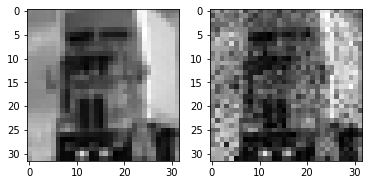

25  :  [0.26964307] 25
50  :  [0.2744311] 25
75  :  [0.30478674] 25
100  :  [0.3043779] 25
125  :  [0.3043779] 25
150  :  [0.30593932] 25
175  :  [0.3043779] 25
200  :  [0.3043779] 25
225  :  [0.3043779] 25
250  :  [0.3043779] 25
275  :  [0.30803627] 25
300  :  [0.30803627] 25
325  :  [0.30803627] 25
350  :  [0.30803627] 25
375  :  [0.30803627] 25
400  :  [0.30803627] 25
425  :  [0.30803627] 25
450  :  [0.3092401] 25
475  :  [0.30934227] 25
500  :  [0.31285536] 25
525  :  [0.31288704] 25
550  :  [0.31288704] 25
575  :  [0.31406492] 25
600  :  [0.314081] 25
625  :  [0.31418875] 25
650  :  [0.31418642] 25
675  :  [0.31418642] 25
700  :  [0.31432855] 25
725  :  [0.31488878] 25
750  :  [0.31493995] 25
775  :  [0.31536245] 25
800  :  [0.31536245] 25
825  :  [0.31539613] 25
850  :  [0.31541902] 25
875  :  [0.31570166] 25
900  :  [0.3157209] 25
925  :  [0.31575817] 25
950  :  [0.31575817] 25
975  :  [0.31582326] 25
1000  :  [0.3162567] 25
1025  :  [0.3162567] 25
1050  :  [0.316284] 25
1075  :

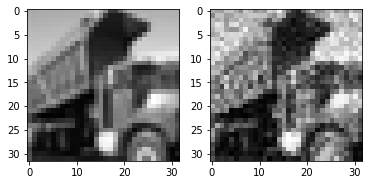

25  :  [0.27817777] 25
50  :  [0.27889082] 25
75  :  [0.27922368] 25
100  :  [0.27928936] 25
125  :  [0.27928936] 25
150  :  [0.27945602] 25
175  :  [0.27964064] 25
200  :  [0.27978185] 25
225  :  [0.2798988] 25
250  :  [0.28043756] 25
275  :  [0.28061426] 25
300  :  [0.28115445] 25
325  :  [0.28123608] 25
350  :  [0.28126103] 25
375  :  [0.28134376] 25
400  :  [0.28171507] 25
425  :  [0.2819863] 25
450  :  [0.28204829] 25
475  :  [0.2821734] 25
500  :  [0.28233844] 25
525  :  [0.28236556] 25
550  :  [0.28264698] 25
575  :  [0.28272027] 25
600  :  [0.28281814] 25
625  :  [0.2829815] 25
650  :  [0.28298795] 25
675  :  [0.2830463] 25
700  :  [0.2830463] 25
725  :  [0.2830879] 25
750  :  [0.28312302] 25
775  :  [0.28324595] 25
NOT IMPROVING!  800  :  [0.28326494] 25
Time:  210.7054591178894  seconds
Predicted class:  [6]


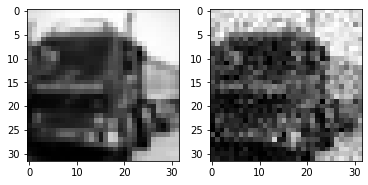

25  :  [0.29038054] 25
50  :  [0.29038054] 25
75  :  [0.2958155] 25
100  :  [0.29632646] 25
125  :  [0.29632533] 25
150  :  [0.29679167] 25
175  :  [0.29681984] 25
200  :  [0.29755053] 25
225  :  [0.29842687] 25
250  :  [0.2987428] 25
275  :  [0.2987428] 25
300  :  [0.2987428] 25
325  :  [0.2987428] 25
350  :  [0.2987428] 25
375  :  [0.2987428] 25
400  :  [0.2987428] 25
425  :  [0.29928103] 25
450  :  [0.29934174] 25
475  :  [0.29934174] 25
500  :  [0.29972] 25
525  :  [0.29972008] 25
550  :  [0.29974377] 25
575  :  [0.29979455] 25
600  :  [0.299833] 25
625  :  [0.3001843] 25
650  :  [0.3002727] 25
675  :  [0.3002727] 25
700  :  [0.30036366] 25
725  :  [0.30036396] 25
750  :  [0.30039793] 25
775  :  [0.30050218] 25
800  :  [0.3005561] 25
825  :  [0.3005561] 25
NOT IMPROVING!  850  :  [0.30070263] 25
Time:  228.08500051498413  seconds
Predicted class:  [6]


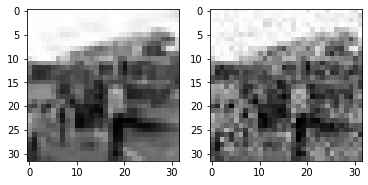

25  :  [0.36148614] 25
50  :  [0.36148614] 25
75  :  [0.36152446] 25
100  :  [0.3623411] 25
125  :  [0.363197] 25
150  :  [0.363197] 25
175  :  [0.363197] 25
200  :  [0.36378342] 25
225  :  [0.36378342] 25
250  :  [0.3638857] 25
275  :  [0.3641894] 25
300  :  [0.3641894] 25
325  :  [0.3641894] 25
350  :  [0.36492842] 25
375  :  [0.36492842] 25
400  :  [0.36492842] 25
425  :  [0.36502385] 25
450  :  [0.36502385] 25
475  :  [0.36502385] 25
500  :  [0.36502385] 25
525  :  [0.36502385] 25
550  :  [0.36502385] 25
575  :  [0.36513197] 25
600  :  [0.36513197] 25
625  :  [0.3651895] 25
650  :  [0.36526215] 25
675  :  [0.36531025] 25
700  :  [0.36534357] 25
725  :  [0.3653735] 25
750  :  [0.3653735] 25
775  :  [0.36537793] 25
NOT IMPROVING!  800  :  [0.365455] 25
Time:  223.34715819358826  seconds
Predicted class:  [6]


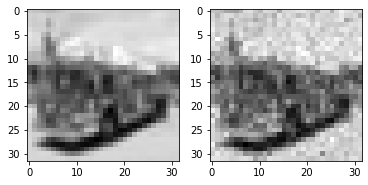

25  :  [0.28953564] 25
50  :  [0.29044086] 25
75  :  [0.29069242] 25
100  :  [0.2907126] 25
125  :  [0.2907126] 25
150  :  [0.2907126] 25
175  :  [0.2907126] 25
200  :  [0.29078326] 25
225  :  [0.29078326] 25
250  :  [0.2918039] 25
275  :  [0.29174754] 25
300  :  [0.29174754] 25
325  :  [0.29174754] 25
350  :  [0.29174754] 25
375  :  [0.29199898] 25
400  :  [0.29200593] 25
425  :  [0.29200593] 25
450  :  [0.29200593] 25
475  :  [0.2925191] 25
500  :  [0.2925191] 25
525  :  [0.2925191] 25
550  :  [0.2925191] 25
575  :  [0.29256696] 25
600  :  [0.29256696] 25
625  :  [0.29256696] 25
650  :  [0.29260534] 25
675  :  [0.2930786] 25
700  :  [0.2931127] 25
725  :  [0.29317367] 25
750  :  [0.29325062] 25
775  :  [0.29325062] 25
800  :  [0.29325062] 25
825  :  [0.29330313] 25
850  :  [0.293688] 25
875  :  [0.293688] 25
900  :  [0.293688] 25
925  :  [0.293688] 25
950  :  [0.29374194] 25
975  :  [0.29374194] 25
1000  :  [0.29374194] 25
NOT IMPROVING!  1025  :  [0.29387134] 25
Time:  293.485386848

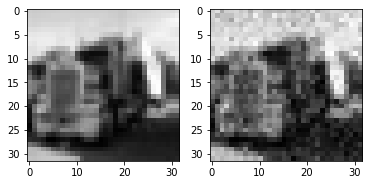

25  :  [0.26999053] 25
50  :  [0.27008379] 25
75  :  [0.2720038] 25
100  :  [0.27203083] 25
125  :  [0.27203083] 25
150  :  [0.27203083] 25
175  :  [0.27203083] 25
200  :  [0.27203083] 25
225  :  [0.27203083] 25
250  :  [0.27225918] 25
275  :  [0.27233064] 25
300  :  [0.27233064] 25
325  :  [0.27233064] 25
350  :  [0.27293754] 25
375  :  [0.27295315] 25
400  :  [0.27323857] 25
425  :  [0.2732495] 25
450  :  [0.27324986] 25
475  :  [0.27346414] 25
500  :  [0.2737081] 25
525  :  [0.27374327] 25
550  :  [0.2738626] 25
575  :  [0.2740897] 25
600  :  [0.274165] 25
625  :  [0.27428252] 25
650  :  [0.27451867] 25
675  :  [0.27469057] 25
700  :  [0.27469057] 25
725  :  [0.27480072] 25
750  :  [0.2748339] 25
775  :  [0.27499086] 25
800  :  [0.27518356] 25
825  :  [0.27521732] 25
NOT IMPROVING!  850  :  [0.2753799] 25
Time:  238.82804203033447  seconds
Predicted class:  [6]


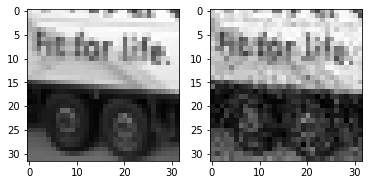

In [10]:
de_npc = DE_NPC(param_dict)
times = []
nfes = []
psnrs = []
predicted_classes = []
for adv_ind in range(91,adversarial.shape[0]):
  de_npc.change_input(adversarial[adv_ind].reshape((32*32,1)),adversarial_y[adv_ind],32*32)
  timed, nfed = de_npc.execute(model)
  times.append(timed)
  nfes.append(nfed)
## increasing coefficient of the first term in fitness function and
## increasing the standard deviation of the noise increases the chance
## to find an adversarial example but it decreases the image quality
## of the adversarial example found
## also this algorithm can discard the best individual in the next generation
## to prevent this we can put it to population[0] after shuffling
  adv = np.clip(de_npc.X_best, 0, 255)
  psnrs.append(PSNR(adversarial[adv_ind],adv))
  preds_adv = model.predict(adv.reshape(1,32,32,1) / 255.0)
  predicted_classes.extend(np.argmax(preds_adv,axis=1))
  print("Predicted class: ",np.argmax(preds_adv,axis=1))
  fig = plt.figure()
  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(adversarial[adv_ind].reshape(32,32),cmap="gray")
  ax2 = fig.add_subplot(1,2,2)
  ax2.imshow(de_npc.X_best.reshape(32,32),cmap="gray")
  plt.show()
  adversarial[adv_ind] = de_npc.X_best.reshape((32,32,1))

airplane										
automobile										
bird										
cat										
deer										
dog										
frog										
horse										
ship										
truck

In [0]:
file_ = open('adv_de_cnn_cifar_part2_seed1', 'wb')
pickle.dump(adversarial, file_)
pickle.dump(times, file_)
pickle.dump(nfes , file_)
pickle.dump(psnrs , file_)
pickle.dump(predicted_classes, file_)
file_.close()

In [12]:
print(np.max(times))
print(np.min(times))
print(np.mean(times))
print(np.std(times))

531.2450342178345
208.31244325637817
313.9594417469842
79.43641648324075


In [13]:
print(np.max(nfes))
print(np.min(nfes))
print(np.mean(nfes))
print(np.std(nfes))

2045
800
1173.2619047619048
300.3543192966956


In [14]:
print(np.max(psnrs))
print(np.min(psnrs))
print(np.mean(psnrs))
print(np.std(psnrs))

19.631965090521575
6.951777731986847
10.139524210792773
2.3314407921268603


# For this one we have to merge output files as they ran simultenously